In [15]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import wfdb
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.python.ops.numpy_ops import np_config
from sklearn.metrics import mean_squared_error

In [16]:
# enable numpy behavior
np_config.enable_numpy_behavior()

In [17]:
data_path = 'mitbih-af/'

In [18]:
# Get the list of all record files in the folder
# List of Patients
data = ['04015','04043','04048','04126','04746','04908','04936','05091',
           '05121','05261','06426','06453','06995','07162','07859','07879',
           '07910','08215','08219','08378','08405','08434','08455']

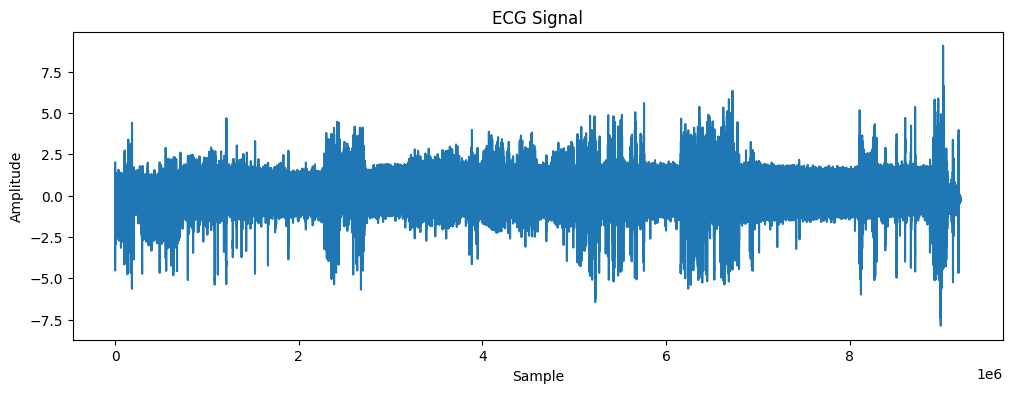

In [19]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [20]:
import numpy as np

# Menghitung kekuatan sinyal (Signal Power)
signal_power = np.var(sig)  # sig adalah sinyal asli

# Menghitung kekuatan noise (Noise Power)
# Untuk data EKG, noise seringkali dianggap sebagai seluruh sinyal karena noise dalam data EKG bervariasi
# Anda dapat menggunakan seluruh sinyal sebagai noise
noise_power = np.var(sig)

# Menghitung SNR
snr = 10 * np.log10(signal_power / noise_power)

print("SNR:", snr)


SNR: 0.0


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [22]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [23]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
# Fungsi untuk menghitung Signal-to-Noise Ratio (SNR)
def calculate_snr(clean_data, denoised_data):
    noise = clean_data - denoised_data
    signal_power = np.sum(clean_data ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [25]:
# Fungsi untuk menghitung Root Mean Square Error (RMSE)
def calculate_rmse(clean_data, denoised_data):
    mse = mean_squared_error(clean_data.flatten(), denoised_data.flatten())
    rmse = np.sqrt(mse)
    return rmse

In [26]:
# Membangun model Deep RNN Autoencoder
def build_autoencoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder = LSTM(latent_dim, return_sequences=True)(inputs)
    encoder = LSTM(latent_dim)(encoder)

    # Decoder
    decoder = RepeatVector(input_shape[0])(encoder)
    decoder = LSTM(latent_dim, return_sequences=True)(decoder)
    decoder = TimeDistributed(Dense(input_shape[1]))(decoder)

    # Membuat model autoencoder
    autoencoder = Model(inputs, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [27]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

Train:  [      0       2       3 ... 2301436 2301437 2301439] Test:  [      1      11      12 ... 2301433 2301434 2301438]
Train data:  [-0.00504903 -0.05811934 -0.03158418 ... -1.56177828 -1.14606081
 -0.81879386] Test data:  [ 0.04802129 -0.04042924  0.0657114  ... -1.51755301 -1.64138375
 -0.85417407]
Epoch 1/100
3596/3596 [==============================] - 38s 8ms/step - loss: 0.0574 - root_mean_squared_error: 0.2396 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0762
Epoch 2/100
3596/3596 [==============================] - 28s 8ms/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 3/100
3596/3596 [==============================] - 28s 8ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 5.2064e-04 - val_root_mean_squared_error: 0.0228
Epoch 4/100
3596/3596 [==============================] - 28s 8ms/step - loss: 7.5794e-04 - root_mean_squared_error: 0.0275 - val_loss: 4.6324e-04 - val_root_mean_

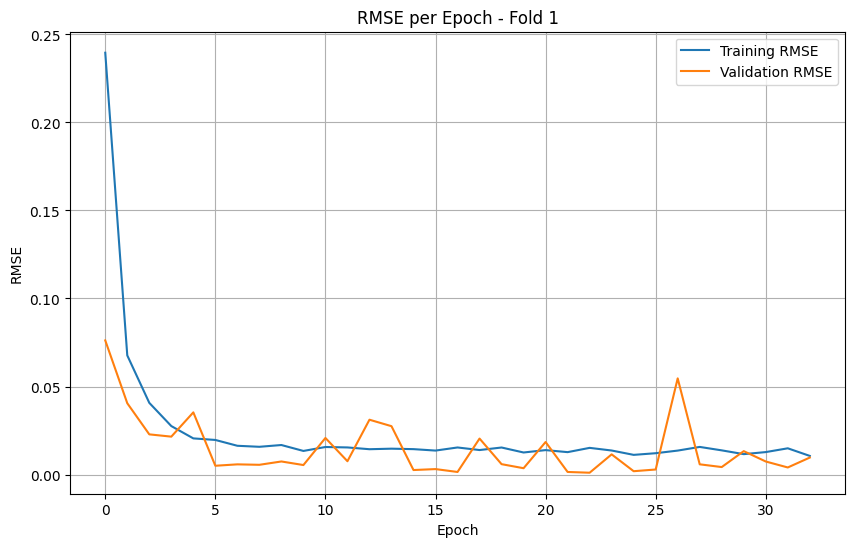

14384/14384 [==============================] - 44s 3ms/step
59.74681072944743
Signal to Noise Ratio (SNR) fold-1: 59.74681072944743
Root Mean Squared Error (RMSE) fold-1: 0.0010295784967240364
Train:  [      1       2       4 ... 2301436 2301438 2301439] Test:  [      0       3       5 ... 2301426 2301429 2301437]
Train data:  [ 0.04802129 -0.05811934  0.00379603 ... -1.56177828 -0.85417407
 -0.81879386] Test data:  [-0.00504903 -0.03158418  0.0657114  ... -2.24284732 -0.68611807
 -1.14606081]
Epoch 1/100
3596/3596 [==============================] - 47s 10ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 2/100
3596/3596 [==============================] - 32s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 3/100
3596/3596 [==============================] - 32s 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 5.4260e-04 - val_

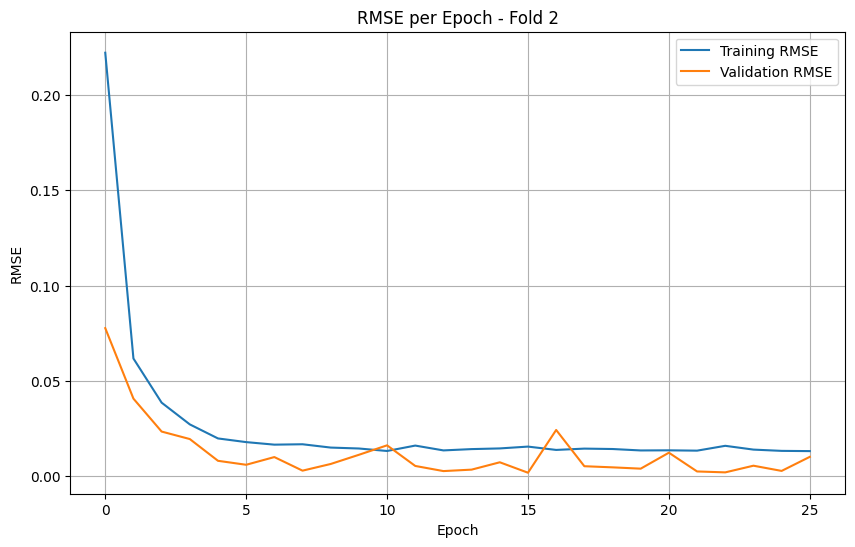

14384/14384 [==============================] - 43s 3ms/step
55.52367746995703
Signal to Noise Ratio (SNR) fold-2: 55.52367746995703
Root Mean Squared Error (RMSE) fold-2: 0.0016742338814826573
Train:  [      0       1       3 ... 2301437 2301438 2301439] Test:  [      2       7      13 ... 2301428 2301435 2301436]
Train data:  [-0.00504903  0.04802129 -0.03158418 ... -1.14606081 -0.85417407
 -0.81879386] Test data:  [-0.05811934 -0.09349955  0.20723224 ... -0.49152692 -1.76521449
 -1.56177828]
Epoch 1/100
3596/3596 [==============================] - 46s 9ms/step - loss: 0.0546 - root_mean_squared_error: 0.2337 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 2/100
3596/3596 [==============================] - 31s 9ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Epoch 3/100
3596/3596 [==============================] - 31s 9ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0016 - val_root_

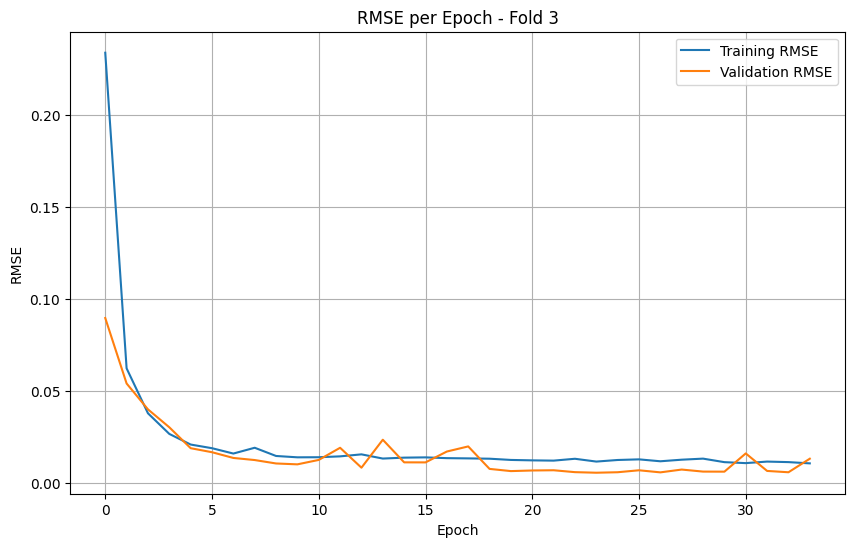

14384/14384 [==============================] - 45s 3ms/step
44.87549884911516
Signal to Noise Ratio (SNR) fold-3: 44.87549884911516
Root Mean Squared Error (RMSE) fold-3: 0.005704598160433018
Train:  [      0       1       2 ... 2301436 2301437 2301438] Test:  [      6       9      10 ... 2301417 2301430 2301439]
Train data:  [-0.00504903  0.04802129 -0.05811934 ... -1.56177828 -1.14606081
 -0.85417407] Test data:  [ 0.01264108  0.11878171  0.00379603 ... -2.64087469 -1.88904522
 -0.81879386]
Epoch 1/100
3596/3596 [==============================] - 54s 11ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 2/100
3596/3596 [==============================] - 36s 10ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 3/100
3596/3596 [==============================] - 36s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0011 - val_roo

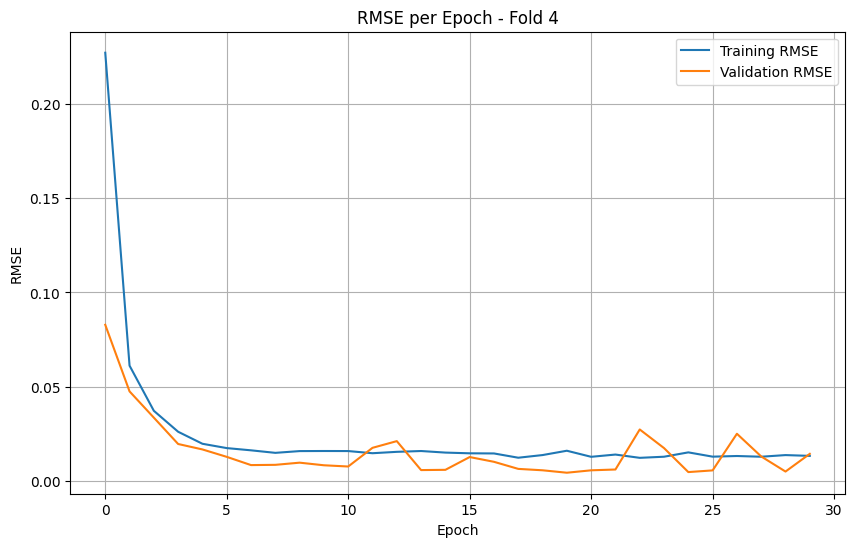

14384/14384 [==============================] - 44s 3ms/step
47.15373163500759
Signal to Noise Ratio (SNR) fold-4: 47.15373163500759
Root Mean Squared Error (RMSE) fold-4: 0.004388472874070153
Train:  [      0       1       2 ... 2301437 2301438 2301439] Test:  [      4       8      15 ... 2301422 2301425 2301432]
Train data:  [-0.00504903  0.04802129 -0.05811934 ... -1.14606081 -0.85417407
 -0.81879386] Test data:  [ 0.00379603  0.04802129  0.01264108 ... -2.08363638 -2.21631217
 -1.9686507 ]
Epoch 1/100
3596/3596 [==============================] - 52s 10ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 2/100
3596/3596 [==============================] - 34s 9ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 3/100
3596/3596 [==============================] - 34s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0011 - val_root

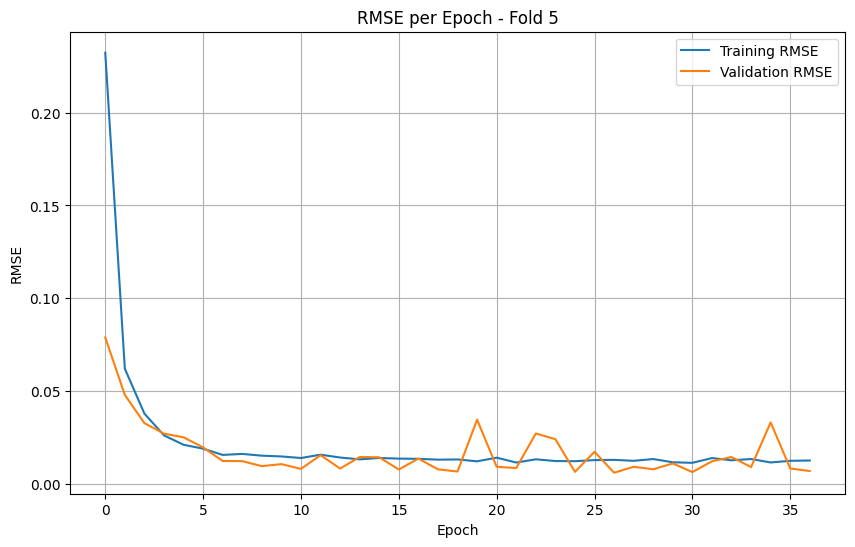

14384/14384 [==============================] - 43s 3ms/step
44.414960928567794
Signal to Noise Ratio (SNR) fold-5: 44.414960928567794
Root Mean Squared Error (RMSE) fold-5: 0.006015226063309314


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

result_snr = []
result_rmse = []
list_denoised_data = []
i = 1
for train, test in kfold.split(sign):
    # Print index data train dan test
    print("Train: ", train, "Test: ", test)
    # Print isi data train dan test
    print("Train data: ", sig[train], "Test data: ", sig[test])

    # Mendapatkan data train dan test
    X_train, X_test = sign[train], sign[test]

    # Pra-pemrosesan data
    X_train = (X_train - np.mean(X_train)) / np.std(X_train)
    X_test = (X_test - np.mean(X_test)) / np.std(X_test)

    # Mengubah dimensi input ke bentuk yang diharapkan oleh layer LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

    # Menentukan dimensi input
    input_shape = X_train.shape[1:]

    # Menentukan dimensi latent space
    latent_dim = 16

    # Membangun model autoencoder
    autoencoder = build_autoencoder(input_shape, latent_dim)
    
    # Compile the model with loss function and metrics
    autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])
    
    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

    # Fit the model with callbacks
    history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=128, validation_data=(X_test, X_test), callbacks=[early_stop])

    # Plot RMSE per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Epoch - Fold {i}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Melakukan denoising pada data test
    denoised_data = autoencoder.predict(X_test)

    # Menghitung SNR dan RMSE
    snr = calculate_snr(X_test, denoised_data)
    print(snr)
    rmse = calculate_rmse(X_test, denoised_data)

    # Tampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    list_denoised_data.append(denoised_data)
    i += 1

In [32]:
# Menambahkan rata-rata dari hasil SNR
average_snr = np.mean(result_snr)

# Mencetak hasil SNR dan rata-rata
k = 1
for snr_value in result_snr:
    print(f"Hasil SNR ke-{k}: {snr_value}")
    k += 1

# Mencetak rata-rata SNR
print(f"Rata-rata SNR: {average_snr}")


Hasil SNR ke-1: 59.74681072944743
Hasil SNR ke-2: 55.52367746995703
Hasil SNR ke-3: 44.87549884911516
Hasil SNR ke-4: 47.15373163500759
Hasil SNR ke-5: 44.414960928567794
Rata-rata SNR: 50.342935922418995


In [33]:
# Menambahkan rata-rata dari hasil RMSE
average_rmse = np.mean(result_rmse)

# Mencetak hasil RMSE dan rata-rata
k = 1
for rmse_value in result_rmse:
    print(f"Hasil RMSE ke-{k}: {rmse_value}")
    k += 1

# Mencetak rata-rata RMSE
print(f"Rata-rata RMSE: {average_rmse}")


Hasil RMSE ke-1: 0.0010295784967240364
Hasil RMSE ke-2: 0.0016742338814826573
Hasil RMSE ke-3: 0.005704598160433018
Hasil RMSE ke-4: 0.004388472874070153
Hasil RMSE ke-5: 0.006015226063309314
Rata-rata RMSE: 0.0037624218952038357
